In [1]:
import sqlite3
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

con = sqlite3.connect('../data/covid.db')
warnings.filterwarnings('ignore', category=FutureWarning)

# Visualisation 1: Cases over time

In [2]:
sql_command1 = '''
SELECT
    cv.date,
    cv.entity,
    cv.cases_per_capita,
    cy.continent
FROM
    Covid cv
    JOIN Country cy
    ON cv.entity = cy.entity
'''

viz1 = pd.read_sql(sql_command1, con).dropna(subset='cases_per_capita')
viz1 = viz1.groupby(['date', 'continent']).mean().reset_index()
fig = px.line(viz1, x='date', y='cases_per_capita', color='continent',
              labels={'cases_per_capita': 'mean cases per capita'},
              title='Mean Covid cases per capita by continent over time')
fig.show()
fig.write_html('../figures/viz1.html')

[Preview Figure 1](https://htmlpreview.github.io/?https://github.com/claudia-liauw/covid-kaggle/blob/master/figures/viz1.html)

Europe has the highest mean cases per capita, while Oceania and Africa have the lowest. The number of cases per capita could be related to population density and global connectivity.

# Visualisation 2: Correlation of factors with number of cases to date

In [3]:
sql_command2 = '''
SELECT
    cy.*,
    cv.date,
    cv.cases,
    cv.deaths,
    cv.cases_per_capita,
    cv.deaths_per_capita
FROM
    Country cy
    JOIN Covid cv
    ON cy.entity = cv.entity
'''

viz2 = pd.read_sql(sql_command2, con)

In [4]:
# Check for date of last available record
viz2.date.value_counts().sort_index().tail(1)

2021-02-28    104
Name: date, dtype: int64

In [5]:
# Retrieve last available record
viz2 = viz2[viz2.date == '2021-02-28']

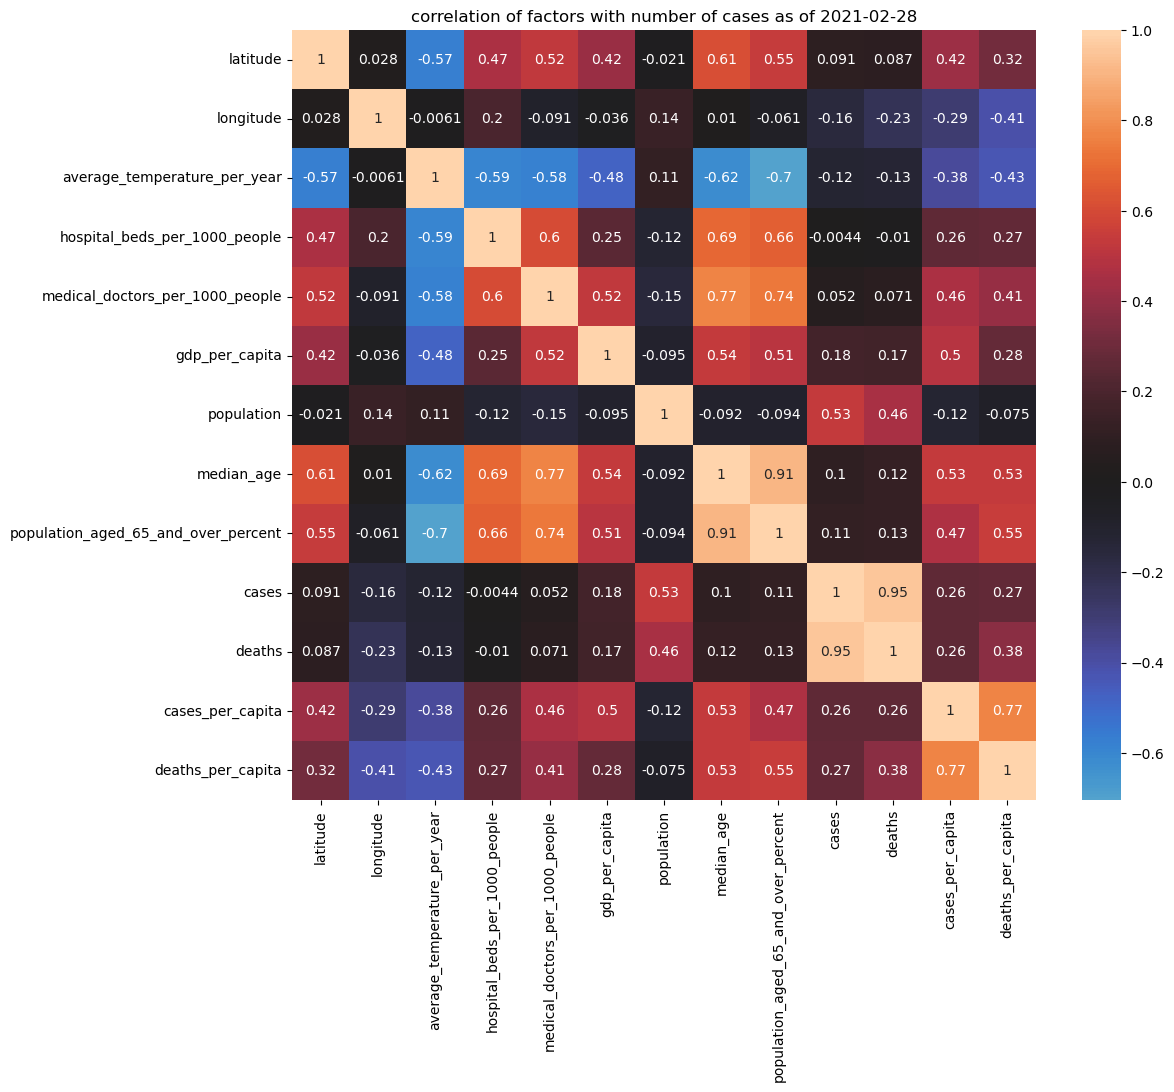

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(viz2.corr(), annot=True, center=0)
plt.title('correlation of factors with number of cases as of 2021-02-28')
fig.savefig('../figures/viz2.png')

There appears to be no strong correlations of cases/deaths with climate, healthcare, economy or demography. 

# Visualisation 3: Relationship of healthcare factors with deaths per cases

In [7]:
sql_command3 = '''
SELECT
    cy.entity,
    cy.continent,
    cy.hospital_beds_per_1000_people,
    cy.medical_doctors_per_1000_people,
    cv.date,
    cv.cases,
    cv.deaths
FROM
    Country cy
    JOIN Covid cv
    ON cy.entity = cv.entity
'''

viz3 = pd.read_sql(sql_command3, con)

# Retrieve last available record
viz3 = viz3[viz3.date == '2021-02-28']

# Calculate deaths per cases ratio
viz3['deaths_per_cases'] = viz3.deaths / viz3.cases


In [8]:
for i, feature in enumerate(['hospital_beds_per_1000_people', 'medical_doctors_per_1000_people']):
    fig = px.scatter(viz3, x=feature, y='deaths_per_cases', color='continent', hover_name='entity',
                     title='Relationship of ' + feature.replace('_', ' ') + ' with deaths per cases')
    fig.show()
    fig.write_html('../figures/viz3-' + str(i) + '.html')

[Preview Figure 3a](https://htmlpreview.github.io/?https://github.com/claudia-liauw/covid-kaggle/blob/master/figures/viz3-0.html)

[Preview Figure 3b](https://htmlpreview.github.io/?https://github.com/claudia-liauw/covid-kaggle/blob/master/figures/viz3-1.html)

It was expected that having more hospital beds or medical doctors may reduce the deaths-to-cases ratio, but there does not seem to be a significant effect.